#Week 2 Homework

###Week 2 Homework 1: A Little Model of Time-Varying Expected Returns 

Expected returns vary over time. Here is a nice structure we use to represent this idea:

$$x_t = \phi x_{t-1} +\epsilon_t$$
$$r_{t+1} = x_t+\delta_{t+1} $$

$x_t$ denotes the expected return, and $r_{t+1}$ denotes the actual log return. (We usually run these in logs, I showed levels in class because it's easier.) Actual returns are expected returns $x_t$ plus unpredictable noise $\delta_{t+1}$. $\epsilon_{t+1}$ and $\delta_{t+1}$ can be correlated -- good returns can be positively or negatively associated with good news about expected returns. In fact, $\epsilon_{t+1}$ and $\delta_{t+1}$ are negatively correlated -- when prices go up we have a good actual return $\delta_{t+1}>0$ but it's bad news for subsequent expected returns $\epsilon_{t+1}<0$. In the lecture, I used $x_t=a+b×dp_t$, but we more generally think of expected returns as following a latent (we can't observe it directly) state variable of this form, and then prices reveal $x_t$ to us.

We use this sort of time series model widely in finance -- for example, all the term structure models are built this way. It's worth getting familiar with it.

When the problem calls for numerical values, use $\sigma_\epsilon=0.018$, $\phi=0.94$, $\sigma_\delta=0.18$ and the correlation between $\epsilon_t$ and $\delta_t$ shocks $\rho=−\frac{\phi}{1−\phi^2}×\frac{\sigma_\epsilon}{\sigma_\delta}=−0.80756$. These numbers are close to what we see in dividend-yield regressions, and the latter number reverse-engineers a very nice special case. 

####Question 1
Suppose you observe $x_t$ directly and perfectly. If you were to run a regression of returns on $x_t$,

$$r_{t+1}=a+bx_t+e_{t+1}$$

in large samples, calculate the values you expect to see of the regression coefficient b, the standard deviation of expected returns $\sigma(a+bx)$, the standard deviation of actual returns $\sigma(r)$ and the $R^2$ of this regression. (I used notation $e_{t+1}$ because this is not the "true" $\delta_{t+1}$ defined in the model, but a regression residual.)

Find the formula for each of these quantities in terms of the given parameters. Then compute them, and report them in order, as numbers separated by spaces. Report standard deviations in net (0.05) not percent (5.00) units. You should input a total of four numbers. 


In [1]:
import numpy as np

sig_epsilon = 0.018
sig_delta = 0.18
phi = 0.94
rho = -(phi / (1 - phi**2)) * (sig_epsilon / sig_delta)
sig_x = sig_epsilon / np.sqrt(1-phi**2)
varret = sig_x**2 + sig_delta**2
b_hat = 1.

print('{0:.0f} {1:6.5f} {2:6.5f} {3:6.5f}'.format(b_hat, b_hat*sig_x, np.sqrt(varret), 
                                                    (b_hat*sig_x/np.sqrt(varret))**2))

1 0.05276 0.18757 0.07911


####Question 2

Simulate a long time series -- at least 100,000 points -- of this model. Use the simulation to check your answers to the last question -- run a regression in simulated data, and see if you get the $b$, $\sigma(a+bx)$ and $R^2$ that you expected. (You can use standard errors to gauge the uncertainty due to a finite sample.)

Hint: you can create a vector of correlated variables from a random number generator by

$$ \begin {bmatrix}
   \epsilon_t \\
   \delta_t\\
   \end {bmatrix} =
   \begin {bmatrix}
   \sigma_\epsilon & 0 \\
   \rho\sigma_\delta & \sigma_\delta \sqrt{1-\rho^2} \\
   \end {bmatrix} 
   \begin {bmatrix}
   z_t \\
   w_t
   \end {bmatrix}$$

where $\begin {bmatrix} z_t \\ w_t \end {bmatrix} ∼N(0,I)$. The 2×2 matrix is the Choleski decomposition of a covariance matrix. If you want to produce a vector of random normals with covariance matrix $\Sigma$, the fact that $chol(\Sigma)chol(\Sigma)′=\Sigma$ means that $chol(\Sigma)×$ a vector of $N(0,I)$ variables will have covariance matrix $\Sigma$.

Now, find the coefficient this model predicts for the 5 year return,

$$(r_{t+1}+r_{t+2}+r_{t+3}+r_{t+4}+r_{t+5})=a_5+b_5x_t+e^{(5)}_{t+5}$$

(I added the superscript "(5)" to clarify these are different residuals than before.) You should calculate the formula for $b_5$ from the model, (i.e. in terms of $\phi,\sigma_\epsilon,\sigma_\delta,\rho$ etc.) and then input numbers. Calculating the $R^2$ in this way is possible but a lot of unpleasant algebra. So instead, run the regression in your simulated data, check the coefficient $b_5$ and just report the $R^2$ that you get from the regression in simulated data. (Big picture: This is a nice way to avoid doing a lot of algebra!)

Report the numerical value of the coefficient $b_5$ and  $R^2$, separated by spaces. 

In [2]:
import pandas as pd
import statsmodels.formula.api as sm


sims = 5000000
# correlation matrix supplied with the problem
S = np.array([[sig_epsilon**2, rho*sig_delta*sig_epsilon], 
              [rho*sig_delta*sig_epsilon, sig_delta**2]])
np.random.seed(42)
# generate correlated gaussians
epsdl = np.random.multivariate_normal(mean=np.zeros(2), cov=S, size=sims)
xobs = np.zeros(sims)
# create x_t as AR1 process from the sigma_epsilon
for i in range(1, sims):
    xobs[i] = phi * xobs[i-1] + epsdl[i,0]

# now realise that we are suppose to regress r_{t+1} against x_t
robs = xobs[:-1] + epsdl[1:,1]

# put the series into a Pandas DataFrame
sim_data = pd.DataFrame({'expected_returns' : xobs[:-1], 'log_returns' : robs})

# call statsmodels.ols on the seires to perform the regressio
res = sm.ols('log_returns ~ expected_returns', data=sim_data).fit()

# display results
print('Simulated b={0:.5f} \nSimulated R^2={1:.5f}'.format(
        res.params.expected_returns, res.rsquared))
res.summary()

Simulated b =0.99970 
 Simulated R^2 =0.07915


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                 4.297e+05
Date:                Wed, 28 Jan 2015   Prob (F-statistic):               0.00
Time:                        14:53:56   Log-Likelihood:             1.4793e+06
No. Observations:             4999999   AIC:                        -2.959e+06
Df Residuals:                 4999997   BIC:                        -2.959e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept        -6.198e-05   8.05e-05     -0.770      0.441        -0.000  9.58e-05
expected_returns     0.9997      0.002    655.548      0.000         0.997     1.003
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.115
Skew:                          -0.000   Prob(JB):                        0.944
Kurtosis:                       3.001   Cond. No.                         18.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
# generate 5 years cumulative returns by summing yearly data
robs_5 = np.convolve(robs, np.ones(5), 'valid')

# wrap series into a Dataframe
sim_5_data = pd.DataFrame({'expected_returns_5' : xobs[:len(robs_5)], 
                           'log_returns_5' : robs_5})

# call statsmodels.ols 
res_5 = sm.ols('log_returns_5 ~ expected_returns_5', data=sim_5_data).fit()

# print results
print('5 Year b={0:.5f} \n5 Year R^2={1:.5f}'.format(
        res_5.params.expected_returns_5, res_5.rsquared))
res_5.summary()

5 Year b=4.42928 
5 Year R^2=0.31129


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_returns_5   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 2.260e+06
Date:                Wed, 28 Jan 2015   Prob (F-statistic):               0.00
Time:                        14:55:56   Log-Likelihood:            -1.8136e+06
No. Observations:             4999995   AIC:                         3.627e+06
Df Residuals:                 4999993   BIC:                         3.627e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             -0.0002      0.000     -1.547      0.122        -0.001  6.43e-05
expected_returns_5     4.4293      0.003   1503.322      0.000         4.424     4.435
==============================================================================
Omnibus:                        9.542   Durbin-Watson:                   0.423
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.506
Skew:                          -0.002   Prob(JB):                      0.00863
Kurtosis:                       2.994   Cond. No.                         18.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####Question 3

Plot 100 points of $x_t$ and $r_{t+1}$ -- line up the data so that the forecast $x_t$ and the actual $r_{t+1}$ are on the same date. If you had only the return data, and could not see the $x_t$, could you see the variation in average returns buried in the noise of actual returns? This plot may give you a sense of why people missed return predictability for so long.

Now plot 100 years of the 5 year return $(r_{t+1}+r_{t+2}+r_{t+3}+r_{t+4}+r_{t+5})$ along with the predicted value from your model, $a_5+b_5x_t$, again lining up $a_5+b_5x_t$ with $r_{t+5}$. This should look quite similar to the graph reported in class using dividend-yield data. The correlation of expected returns with actual returns should be much clearer, as the $R^2$ is much higher. 

/usr/local/lib/python3.4/dist-packages/matplotlib-1.5.x-py3.4-linux-x86_64.egg/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


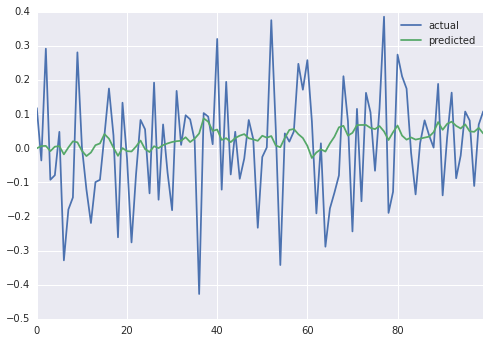

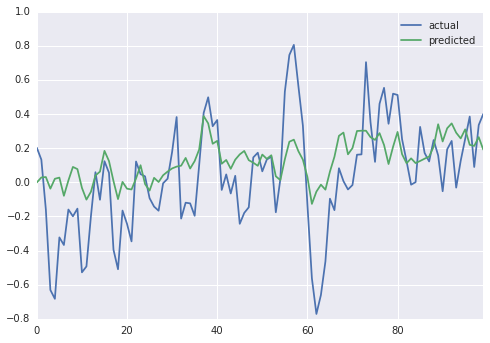

In [4]:
%matplotlib inline
import seaborn as sns

comp_1 = pd.DataFrame({'predicted' : res.fittedvalues , 'actual' : robs})
comp_5 = pd.DataFrame({'predicted' : res_5.fittedvalues , 'actual' : robs_5})

comp_1[:100].plot()
comp_5[:100].plot();

####Question 4

At this point you should have a sense that this model produces artificial data that looks pretty much like our forecasts of returns from dividend yields, and it integrates the long run and short run observations.

But how is that consistent with our forecasts of returns from past returns? If returns are truly predictable from dividend yields, why do we not see that when we forecast using past returns? After all, the main way a dividend yield gets high is for the price to decline. Does the forecastability of returns from dividend yields mean that returns really are "safer" for long run investors who can afford to wait out the "temporary declines" in stock prices?

To answer all these questions, we need to find what our little model predicts for the forecast of returns based on past returns. It is possible to find algebraically what the univariate return process that our little system implies. It turns out that returns follow an ARMA(1,1), $r_{t+1}=\phi r_t+v_t -\theta v_{t−1}$ where $v_t$ is the regression shock. But rather than do a lot of algebra at this point, let's attack the question by simulation:

In your long artificial data set, run the regression $r_{t+1}=a+br_t+v_{t+1}$, and report $b$ and the $R^2$.

In [5]:
# construct the dataframe
forecast_ret = pd.DataFrame({'prev_ret' : robs[:-1],'next_ret' : robs[1:]})

# call sm.ols
res_fcast = sm.ols('next_ret ~ prev_ret', data=forecast_ret).fit()

# print and display results
print('b={0:.5f} R^2={1:5f}'.format(res_fcast.params.prev_ret, res_fcast.rsquared))
res_fcast.summary()

b=-0.00107 R^2=0.000001


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               next_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.733
Date:                Wed, 28 Jan 2015   Prob (F-statistic):             0.0166
Time:                        14:57:40   Log-Likelihood:             1.2732e+06
No. Observations:             4999998   AIC:                        -2.546e+06
Df Residuals:                 4999996   BIC:                        -2.546e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   6.029e-05   8.39e-05      0.719      0.472        -0.000     0.000
prev_ret      -0.0011      0.000     -2.394      0.017        -0.002    -0.000
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.183
Skew:                          -0.000   Prob(JB):                        0.912
Kurtosis:                       2.999   Cond. No.                         5.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###Week 2 Homework 2: Meet the Binomial Model

The binomial model is really useful in asset pricing. Suppose that there are two states tomorrow,"up" and "down," and each can happen with probability $\frac{1}{2}$. Consumption is $c_t=1$ today, $c_{t+1}(u)=2$ in the up state and $c_{t+1}(d)=\frac{1}{2}$ in the down state. Assume $\gamma=1$, $\beta=1$ and power utility $u^\prime(c)=c^{−\gamma}$

This assignment introduces the binomial setup. I set it up so the payoffs are very symmetric, yet the model generates very asymmetric prices and expected returns. Ponder why.

Start by writing down a general asset pricing formula. If a payoff is $x(u)$ and $x(d)$ in the up and down states at time t+1, write a formula for its price at time t. Then you can do the examples that follow. 

####Question 1

Find the price of a bond -- an asset that pays 1 in each state. Enter your answer as a decimal 

In [6]:
def price(p, c_u, c_d, x_u, x_d):
    return sum([p/c_u*x_u, (1-p)/c_d*x_d])

p = 0.5
c_u = 2
c_d = 0.5
x_u = x_d = 1

price(p, c_u, c_d, x_u, x_d)

1.25

####Question 2

Find the price of risky asset A that pays x=+1 in the up state, and x=−1 in the down state.

In [7]:
x_u = 1
x_d = -1

price(p, c_u, c_d, x_u, x_d)

-0.75

####Question 3

Find the price of risky asset B that pays x=−1 in the up state and x=+1 in the down state

In [8]:
x_u = -1
x_d = 1

price(p, c_u, c_d, x_u, x_d)

0.75

####Question 4

Compare assets A and B. Check the correct options, and leave blank the incorrect options. 

1. The expected payoff of A equals the expected payoff of B, and the volatility of the A payoff equals the volatility of the B payoff, so they must have the same price.

2. The price of A is less than the price of B, so it has a higher expected payoff.

3. The price of A is less than the price of B, so it has a higher expected return.

4. Two assets can have the same mean and variance of payoff, but different prices.

The correct options are the last two, 3 and 4

####Question 5

Find the price of contingent claims -- an asset that pays \$1 in the up state and \$0 in the down state, and a different asset that pays \$0 in the up state and \$1 in the down state. Enter your answers as two numbers separated by a space, starting with the up-state claim.


In [9]:
x_1_u = 1
x_1_d = 0
x_2_u = 0
x_2_d = 1

print (price(p, c_u, c_d, x_1_u, x_1_d), price(p, c_u, c_d, x_2_u, x_2_d))

0.25 1.0
